In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
data_final=pd.read_csv("/content/finance_data.csv")

In [95]:
df = data_final[data_final['US_Bank'] == 'BAC'].copy()

# Chuyển Date sang datetime và sort
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Reset index integer để tránh lỗi ARIMA
df.reset_index(drop=True, inplace=True)
df['Close'].ffill(inplace=True)  # điền NaN

print("Dữ liệu đầu:", df.head())


Dữ liệu đầu:    Unnamed: 0       Date US_Bank       Open       High        Low      Close  \
0           0 2015-10-14     BAC  15.770000  15.920000  15.550000  15.640000   
1           1 2015-10-15     BAC  15.810000  16.280001  15.720000  16.190001   
2           2 2015-10-16     BAC  16.290001  16.290001  16.030001  16.120001   
3           3 2015-10-19     BAC  16.000000  16.209999  15.980000  16.139999   
4           4 2015-10-20     BAC  16.160000  16.290001  16.100000  16.200001   

   Adjusted Close     Volume  
0       12.591779  122272400  
1       13.034586  127028800  
2       12.978229   66989500  
3       12.994333   62953500  
4       13.042639   50797800  


/tmp/ipython-input-2265229744.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Close'].ffill(inplace=True)  # điền NaN


#Applying time series modelling to build algorithms trading

##Kiểm tra stationary: phương pháp phổ biến Augmented Dickey-Fuller (ADF) test.

Nếu p<=0.05->stationary->có thể dùng AR,MA trực tiếp

Nếu không->cần differencing hoặc log turn để đạt stationarity

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# -------------------------
# Kiểm tra Stationarity
# -------------------------
def check_stationarity(series, signif=0.05):
    result = adfuller(series)
    print(result)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:', key, value)
    if result[1] < signif:
        print("Chuỗi là stationary")
        return True
    else:
        print("Chuỗi là non-stationary")
        return False

# Kiểm tra giá đóng cửa
print("Kiểm tra stationarity của Close Price:")
check_stationarity(df['Close'])


Kiểm tra stationarity của Close Price:
(np.float64(-1.5357582723734087), np.float64(0.5157539530054754), 8, 2504, {'1%': np.float64(-3.4329642237790847), '5%': np.float64(-2.862694950990622), '10%': np.float64(-2.5673848250020415)}, np.float64(4351.767252399381))
ADF Statistic: -1.5357582723734087
p-value: 0.5157539530054754
Critical Values: 1% -3.4329642237790847
Critical Values: 5% -2.862694950990622
Critical Values: 10% -2.5673848250020415
Chuỗi là non-stationary


False

p-value=0.5157>0.05->Chuỗi là non-stationary, để stationary ADF phải nhỏ hơn critical value
=> non-stationary vì Giá cổ phiếu là random walk

In [97]:
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna() #item đầu

In [98]:
check_stationarity(df['LogRet'])

(np.float64(-15.944055322850323), np.float64(7.484200327892872e-29), 8, 2503, {'1%': np.float64(-3.4329652692893364), '5%': np.float64(-2.8626954126892405), '10%': np.float64(-2.567385070816339)}, np.float64(-12494.324380495702))
ADF Statistic: -15.944055322850323
p-value: 7.484200327892872e-29
Critical Values: 1% -3.4329652692893364
Critical Values: 5% -2.8626954126892405
Critical Values: 10% -2.567385070816339
Chuỗi là stationary


True

volatility clustering tồn tại=>GARCH có thể được áp dụng, Không dùng ARIMA trực tiếp cho Price

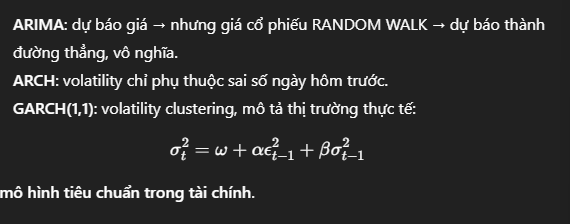

#Fit GARCH Model

In [99]:
# Tính log return
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

# Chia dữ liệu train/test (80% train, 20% test)
split_point = int(len(df) * 0.8)
train = df['LogRet'].iloc[:split_point]
test  = df['LogRet'].iloc[split_point:]

train_dates = df['Date'].iloc[:split_point]
test_dates  = df['Date'].iloc[split_point:]

print("Train size:", len(train))
print("Test size:", len(test))



Train size: 2008
Test size: 503


In [100]:
!pip install arch
from arch import arch_model

# Fit GARCH(1,1)
model = arch_model(train, p=1, q=1, vol="GARCH")#GARCH(1,1) mô hình hóa volatility clustering tốt nhất.
res = model.fit(update_freq=10)# update_freq=10 → chỉ in log mỗi 10 vòng lặp, tránh spam console

print(res.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: -5248.52236465508
            Iterations: 6
            Function evaluations: 50
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 LogRet   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5248.52
Distribution:                  Normal   AIC:                          -10489.0
Method:            Maximum Likelihood   BIC:                          -10466.6
                                        No. Observations:                 2008
Date:                Sat, Dec 06 2025   Df Residuals:                     2007
Time:                        04:35:09   Df Model:                            1
                                 Mean Model                                 
     

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [101]:
vol_forecast = []
history = train.copy()

for i in range(len(test)):
    model = arch_model(history, p=1, q=1, vol="GARCH")
    res = model.fit(disp="off")

    # 1-step ahead volatility
    f = res.forecast(horizon=1)
    sigma = np.sqrt(f.variance.iloc[-1, 0])

    vol_forecast.append(sigma)

    # Append thực tế vào history
    history = pd.concat([history, pd.Series(test.iloc[i:i+1])])



/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00042. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004202. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.p

#Kết hợp test set vào dataframe

In [102]:
df_test = df.iloc[split_point:].copy()
df_test["VolForecast"] = vol_forecast


#Trading Strategy using Volatility

##VolForecast vs MA20 (Rolling Window)

Vol thấp → BUY

Vol cao → CASH

rolling window 20 ngày để tính MA&STD

In [111]:
df_test["Vol_MA20"] = df_test["VolForecast"].rolling(20).mean()

df_test["Signal1"] = 0
df_test.loc[df_test["VolForecast"] < df_test["Vol_MA20"], "Signal1"] = 1

df_test["Signal1"] = df_test["Signal1"].shift(1)



##Bollinger Band Width (BBW)

In [115]:
df_test["MA20"] = df_test["Close"].rolling(20).mean()
df_test["STD20"] = df_test["Close"].rolling(20).std()

df_test["Upper"] = df_test["MA20"] + 2 * df_test["STD20"]
df_test["Lower"] = df_test["MA20"] - 2 * df_test["STD20"]

df_test["BBW"] = (df_test["Upper"] - df_test["Lower"]) / df_test["MA20"]




In [117]:
threshold = df_test["BBW"].median()  # dùng median làm ngưỡng

df_test["Signal2"] = 0
df_test.loc[df_test["BBW"] < threshold, "Signal2"] = 1
df_test["Signal2"] = df_test["Signal2"].shift(1)


Khi signal=1 thì nhận được lợi nhuận bằng LogRet của ngày đó

#Backtest Strategy

Chiến lược 1

In [113]:
df_test["Ret_Strategy1"] = df_test["Signal1"] * df_test["LogRet"]
df_test["Cum_Strategy1"] = (1 + df_test["Ret_Strategy1"]).cumprod()


Chiến lược 2

In [118]:
df_test["Ret_Strategy2"] = df_test["Signal2"] * df_test["LogRet"]
df_test["Cum_Strategy2"] = (1 + df_test["Ret_Strategy2"]).cumprod()



Buy&Hold

In [119]:
df_test["Cum_BuyHold"] = (1 + df_test["LogRet"]).cumprod()


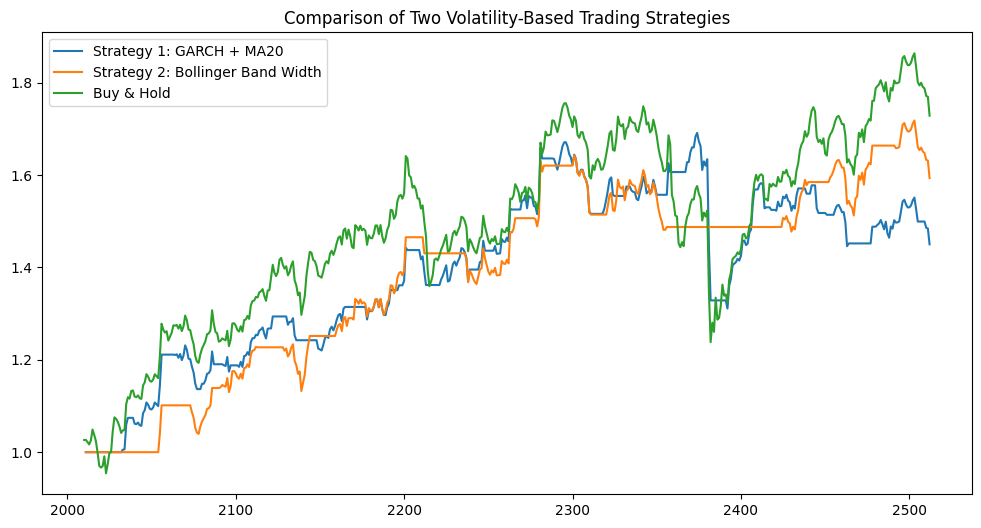

In [120]:
plt.figure(figsize=(12,6))
plt.plot(df_test["Cum_Strategy1"], label="Strategy 1: GARCH + MA20")
plt.plot(df_test["Cum_Strategy2"], label="Strategy 2: Bollinger Band Width")
plt.plot(df_test["Cum_BuyHold"], label="Buy & Hold")
plt.legend()
plt.title("Comparison of Two Volatility-Based Trading Strategies")
plt.show()


In [122]:
def sharpe(x):
    x = x.dropna()
    return (x.mean() / x.std()) * np.sqrt(252)

def max_drawdown(series):
    roll_max = series.cummax()
    dd = series / roll_max - 1
    return dd.min()

print("Sharpe Strategy 1:", sharpe(df_test["Ret_Strategy1"]))
print("Sharpe Strategy 2:", sharpe(df_test["Ret_Strategy2"]))
print("Sharpe BuyHold:",   sharpe(df_test["LogRet"]))

print("MDD Strategy 1:", max_drawdown(df_test["Cum_Strategy1"]))
print("MDD Strategy 2:", max_drawdown(df_test["Cum_Strategy2"]))
print("MDD BuyHold:",     max_drawdown(df_test["Cum_BuyHold"]))


Sharpe Strategy 1: 1.0138648262256607
Sharpe Strategy 2: 1.512281554521296
Sharpe BuyHold: 1.1908075491008665
MDD Strategy 1: -0.22481800374201533
MDD Strategy 2: -0.10034075649299323
MDD BuyHold: -0.2946844360499361


Sharpe Ratio đo chất lượng lợi nhuận đã điều chỉnh theo rủi ro.
Sharpe càng cao → Lợi nhuận trên mỗi đơn vị rủi ro càng tốt.

Strategy 1 (GARCH + MA20)

Sharpe = 1.01 → Tốc độ sinh lợi “ổn”, rủi ro vừa phải.
Ý nghĩa:

Dùng volatility forecast từ GARCH có lợi, nhưng lag do MA20 nên tín hiệu phản ứng chậm.

Strategy 2 (Bollinger Band Width)

Sharpe = 1.51 → Tốt nhất trong 3 chiến lược
Ý nghĩa:

Bollinger Band phản ứng trực tiếp với volatility thực (std) → signal nhạy hơn

Loại bỏ giai đoạn biến động cao hiệu quả hơn

✔ Buy & Hold

Sharpe = 1.19 → Tốt hơn Strategy 1, nhưng kém Strategy 2
Ý nghĩa:

Giữ cổ phiếu lâu dài vẫn hiệu quả, nhưng rủi ro cao → drawdown lớn.

Max Drawdown = mức thua lỗ lớn nhất từ đỉnh → đáy.
MDD càng nhỏ → chiến lược càng an toàn.

✔ Strategy 1: -22.48%

→ Giảm rủi ro so với Buy & Hold, nhưng vẫn khá lớn.

✔ Strategy 2: -10.03%

→ An toàn nhất
→ Bollinger Band giúp né được các vùng market shock tốt hơn vì dựa trên độ co/giãn của volatility.

✔ Buy & Hold: -29.46%

→ Rủi ro rất cao, drawdown sâu khi thị trường biến động mạnh.

Strategy 2 (Bollinger Band Width) là chiến lược tốt nhất.

Sharpe Ratio cao nhất (1.51): Lợi nhuận điều chỉnh theo rủi ro vượt trội

Max Drawdown thấp nhất (-10%): Rủi ro cực thấp

Tín hiệu nhạy, phản ứng đúng bản chất volatility

Phù hợp thực chiến hơn → được nhiều trader tổ chức sử dụng